In [3]:
from APP_Constants import APP_constants as CN
from APP_logger.app_logger import APP_Logger
from APP_utils.common_utils import reduce_memory_usage ,  profile_report_ , Read_data_MONGO
from APP_Database_operations.mongodb_operations import MongoDB

import os


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle


In [6]:
lg = APP_Logger("EDA")


In [61]:
def Load_and_transform(MONGO_DB =CN.MONGO_DB_NAME ,TRAIN_COLLECTION= CN.MONGO_TRAIN_COLLECTION , 
                        PROCESSED_COLLECTION = CN.MONGO_PROCESSED_COLLECTION
                        ,PROCESSED_DATA=CN.PROCESSED_DATA_DIR ,CURRENT_DATE = CN.CURRENT_TIME_STAMP , 
                        IMPUTER_DIR = CN.IMPUTER_DIR , SCALER_DIR = CN.SCALER_DIR):


                        lg.info("Loading Raw_data from MongoDB")
                        Conn_obj_Train = MongoDB( MONGO_DB , TRAIN_COLLECTION)
                        Conn_obj_Processed = MongoDB( MONGO_DB , PROCESSED_COLLECTION)
                        Conn_obj_Processed.drop_collection(PROCESSED_COLLECTION)
                        lg.info("Dropped Collection : {}".format(PROCESSED_COLLECTION))

                        train_data_df = Read_data_MONGO(Conn_obj_Train , Del_id = True)
                        lg.info("Loaded Raw_data from MongoDB as Dataframe")
                        train_data_df = reduce_memory_usage(train_data_df)
                        
                        train_data_df.drop(['month' , 'year' , 'day'], axis=1, inplace=True)
                        lg.info("Dropped columns : 'month' , 'year' , 'day' from Dataframe , as they are not significant")
                        
                        data_df = train_data_df.copy()
                        categorical_columns = data_df.select_dtypes(include=['category']).columns
                        data_df[categorical_columns] = data_df[categorical_columns].apply(lambda x: x.cat.codes)
                        lg.info("Converted categorical columns to numerical columns")
                        scaler = StandardScaler()
                        data_df[data_df.columns] = scaler.fit_transform(data_df)
                        lg.info("Scaled Dataframe")
                        pickle.dump(scaler, open(os.path.join(SCALER_DIR, CURRENT_DATE + '_' + "scaler.pkl"), 'wb'))
                        lg.info(f"Saved scaler as pickle file{SCALER_DIR}")
                        neighbors = len(data_df['Classes'].unique())
                        imputer = KNNImputer(n_neighbors=neighbors)
                        data_imputed = pd.DataFrame(imputer.fit_transform(data_df ), columns=data_df.columns)
                        lg.info("Imputed Dataframe")
                        pickle.dump(imputer, open(os.path.join(IMPUTER_DIR, CURRENT_DATE + '_' + "imputer.pkl"), 'wb'))
                        lg.info(f"Saved imputer as pickle file{IMPUTER_DIR}")
                        Rain_q1 = data_imputed['Rain'].quantile(0.25)
                        Rain_q3 = data_imputed['Rain'].quantile(0.75)
                        Rain_iqr = Rain_q3 - Rain_q1
                        Rain_upper = Rain_q3 + (Rain_iqr * 1.5)
                        Rain_lower = Rain_q1 - (Rain_iqr * 1.5)
                        data_imputed['Rain'] = data_imputed['Rain'].clip(lower=Rain_lower, upper=Rain_upper)
                        lg.info("Clipped Rain column")
                        data_imputed['Classes'] = train_data_df['Classes']
                        Filename = os.path.join(PROCESSED_DATA, CURRENT_DATE + '_' + "processed_data.csv")
                
                        data_imputed.to_csv(Filename, index=False)
                        lg.info("Saved processed data as csv file in {}".format(PROCESSED_DATA))
                        processed_data = data_imputed.to_dict('records')
                        Conn_obj_Processed.insert_many__(processed_data)
                        lg.info(f"Inserted processed data into MongoDB {PROCESSED_COLLECTION}")

                        return True



                        
                        


In [62]:
Load_and_transform()

Loading Raw_data from MongoDB
Collection:'PROCEEDED_DATA' in Database:' does not exists OR 
        no documents are present in the collection
collection not present in the database
Dropped Collection : PROCEEDED_DATA
Reading the data from the database
Dataframe created successfully
Loaded Raw_data from MongoDB as Dataframe
Memory usage decreased from 0.05MB to 0.01MB (0.04MB, 80.21% reduction)
Dropped columns : 'month' , 'year' , 'day' from Dataframe , as they are not significant
Converted categorical columns to numerical columns
Scaled Dataframe
Saved scaler as pickle file/home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/SCALER_DIR
Imputed Dataframe
Saved imputer as pickle file/home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/IMPUTER_DIR
Clipped Rain column
Saved processed data as csv file in /home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/PROCEEDED_DATA
Inserted processed data into MongoDB PROCEEDED_DATA


True

In [13]:
MONGO_DB =CN.MONGO_DB_NAME 
PREPROCESSING_COLLECTION = CN.MONGO_PREPROCESSING_COLLECTION
TRAIN_COLLECTION= CN.MONGO_TRAIN_COLLECTION 
EST_COLLECTION = CN.MONGO_TEST_COLLECTION 

In [14]:
Conn_obj_Train = MongoDB( MONGO_DB , TRAIN_COLLECTION)
train_data_df = Read_data_MONGO(Conn_obj_Train , Del_id = True)

Reading the data from the database
Dataframe created successfully


In [11]:
train_data_df

day  month  year  Temperature    RH    Ws  Rain       FFMC        DMC  \
0      3      6  2012         29.0  80.0  14.0   2.0  48.700001   2.200000   
1     24      8  2012         35.0  38.0  15.0   0.0  92.099998  51.299999   
2     16      6  2012         29.0  89.0  13.0   0.7  36.099998   1.700000   
3     17      7  2012         32.0  81.0  17.0   0.0  84.599998  21.100000   
4     18      8  2012         36.0  54.0  18.0   0.0  89.400002  20.000000   
..   ...    ...   ...          ...   ...   ...   ...        ...        ...   
189    6      9  2012         34.0  71.0  14.0   6.5  64.500000   3.300000   
190   15      9  2012         32.0  51.0  13.0   0.0  88.699997  16.000000   
191   24      8  2012         34.0  64.0  14.0   0.0  88.900002  40.500000   
192    3      6  2012         26.0  82.0  22.0  13.1  47.099998   2.500000   
193   23      9  2012         32.0  54.0  11.0   0.5  73.699997   7.900000   

             DC   ISI        BUI   FWI  Classes                         forest  
0      7.600000   0.3   2.600000   0.1  No Fire  Sidi-Bel Abbes Region Dataset  
1    147.699997  12.2  54.900002  26.9     Fire  Sidi-Bel Abbes Region Dataset  
2      7.600000   0.0   2.200000   0.0  No Fire          Bejaia Region Dataset  
3     42.299999   4.7  20.900000   7.7     Fire  Sidi-Bel Abbes Region Dataset  
4    110.900002   9.7  27.500000  16.1     Fire          Bejaia Region Dataset  
..          ...   ...        ...   ...      ...                            ...  
189    9.100000   1.0   3.500000   0.4  No Fire  Sidi-Bel Abbes Region Dataset  
190   50.200001   6.9  17.799999   9.8     Fire  Sidi-Bel Abbes Region Dataset  
191  171.300003   9.0  50.900002  20.9     Fire          Bejaia Region Dataset  
192    7.100000   0.3   2.700000   0.1  No Fire          Bejaia Region Dataset  
193   30.400000   1.2   9.600000   0.7  No Fire          Bejaia Region Dataset  

[194 rows x 15 columns]

In [12]:
train_data_df = reduce_memory_usage(train_data_df)

Memory usage decreased from 0.05MB to 0.01MB (0.04MB, 80.21% reduction)


In [13]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   day          194 non-null    int8    
 1   month        194 non-null    int8    
 2   year         194 non-null    int16   
 3   Temperature  194 non-null    float32 
 4   RH           194 non-null    float32 
 5   Ws           194 non-null    float32 
 6   Rain         194 non-null    float32 
 7   FFMC         194 non-null    float32 
 8   DMC          194 non-null    float32 
 9   DC           194 non-null    float32 
 10  ISI          194 non-null    float32 
 11  BUI          194 non-null    float32 
 12  FWI          193 non-null    float32 
 13  Classes      194 non-null    category
 14  forest       194 non-null    category
dtypes: category(2), float32(10), int16(1), int8(2)
memory usage: 9.1 KB


In [14]:
data = train_data_df.copy()

In [15]:
profile_report_(data , title='PREPROCESSING' , display_report=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile Report Generated for PREPROCESSING saved to /home/pk/Desktop/Eda/Algerian_forest_fires_dataset/templates/PREPROCESSING_profile.html


ClassificatioN

<AxesSubplot:xlabel='day', ylabel='Temperature'>

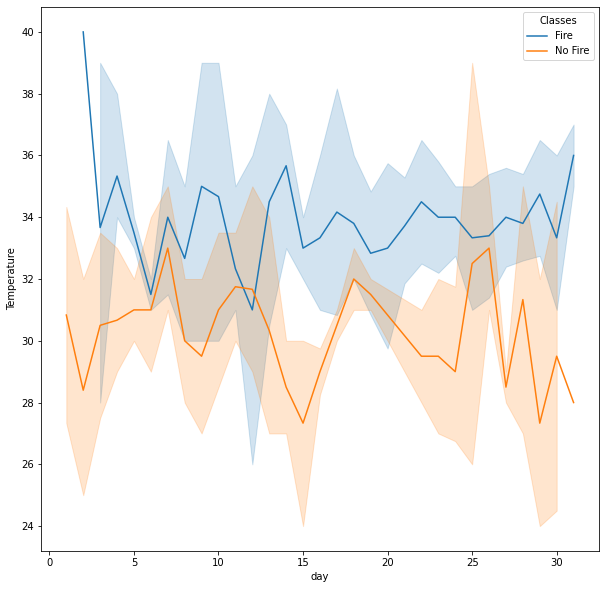

In [16]:
plt.figure(figsize=(10,10))
sns.lineplot(x='day', y = "Temperature", data=data , hue='Classes')

<AxesSubplot:xlabel='month', ylabel='Temperature'>

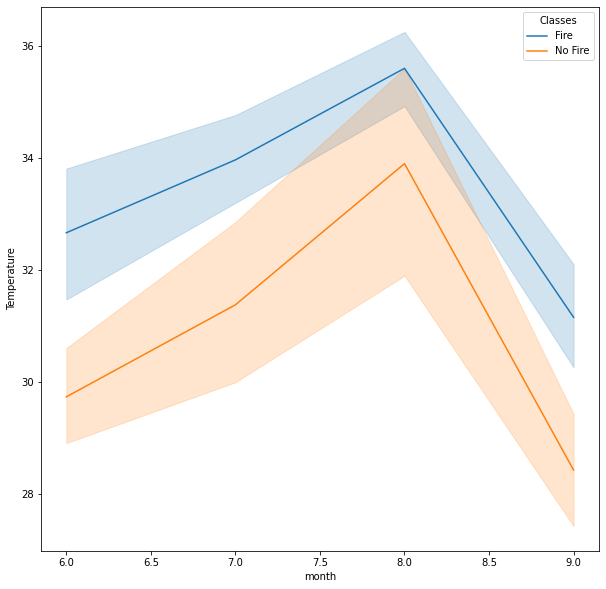

In [17]:
plt.figure(figsize=(10,10))
sns.lineplot(x='month', y = "Temperature", data=data , hue='Classes')

In [18]:
data.groupby('month')['Classes'].value_counts()

month         
6      No Fire    23
       Fire       21
7      Fire       30
       No Fire    21
8      Fire       40
       No Fire    10
9      No Fire    30
       Fire       19
Name: Classes, dtype: int64

we will drop the year, day , month from the dataframe

In [19]:
train_data_df.drop(['month' , 'year' , 'day'], axis=1, inplace=True)
data.drop(['month' , 'year' , 'day'], axis=1, inplace=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Temperature  194 non-null    float32 
 1   RH           194 non-null    float32 
 2   Ws           194 non-null    float32 
 3   Rain         194 non-null    float32 
 4   FFMC         194 non-null    float32 
 5   DMC          194 non-null    float32 
 6   DC           194 non-null    float32 
 7   ISI          194 non-null    float32 
 8   BUI          194 non-null    float32 
 9   FWI          193 non-null    float32 
 10  Classes      194 non-null    category
 11  forest       194 non-null    category
dtypes: category(2), float32(10)
memory usage: 8.3 KB


In [21]:
data['Classes'].unique()

['No Fire', 'Fire']
Categories (2, object): ['Fire', 'No Fire']

In [22]:
neighbors = len(data['Classes'].unique())
imputer = KNNImputer(n_neighbors=neighbors)

In [23]:
categorical_columns = data.select_dtypes(include=['category']).columns

In [24]:
categorical_columns

Index(['Classes', 'forest'], dtype='object')

In [25]:
data[categorical_columns] = data[categorical_columns].apply(lambda x: x.cat.codes)

In [26]:
data_imputed = pd.DataFrame(imputer.fit_transform(data) , columns=data.columns)

In [27]:
data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  194 non-null    float32
 1   RH           194 non-null    float32
 2   Ws           194 non-null    float32
 3   Rain         194 non-null    float32
 4   FFMC         194 non-null    float32
 5   DMC          194 non-null    float32
 6   DC           194 non-null    float32
 7   ISI          194 non-null    float32
 8   BUI          194 non-null    float32
 9   FWI          194 non-null    float32
 10  Classes      194 non-null    float32
 11  forest       194 non-null    float32
dtypes: float32(12)
memory usage: 9.2 KB


In [28]:
train_data_df['FWI'].isnull().sum()

1

Imputed_data is transfered to the training data

In [29]:
train_data_df['FWI'] = data_imputed['FWI']

In [30]:
train_data_df['FWI'].isnull().sum()

0

In [31]:
features = train_data_df.drop(['Classes'], axis=1)
labels = train_data_df['Classes']

<AxesSubplot:>

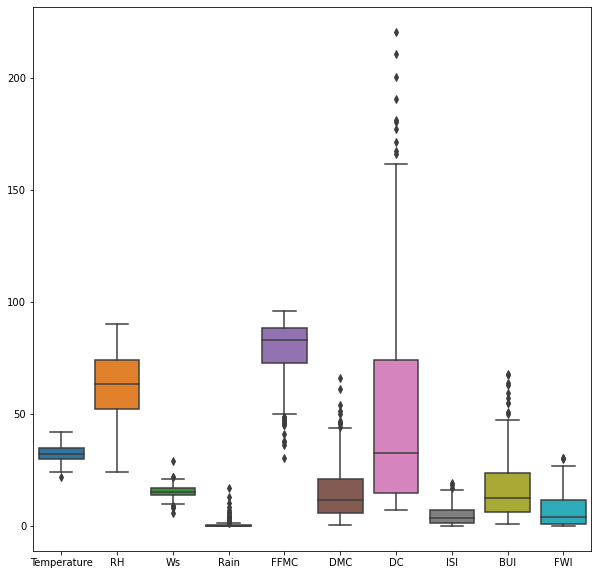

In [32]:
plt.figure(figsize=(10,10))
sns.boxplot(data=train_data_df)

In [33]:
features = reduce_memory_usage(features)

Memory usage decreased from 0.01MB to 0.01MB (0.00MB, 0.00% reduction)


In [34]:
categorical_columns = features.select_dtypes(include=['category']).columns

In [35]:
features[categorical_columns] = features[categorical_columns].apply(lambda x: x.cat.codes)

<AxesSubplot:>

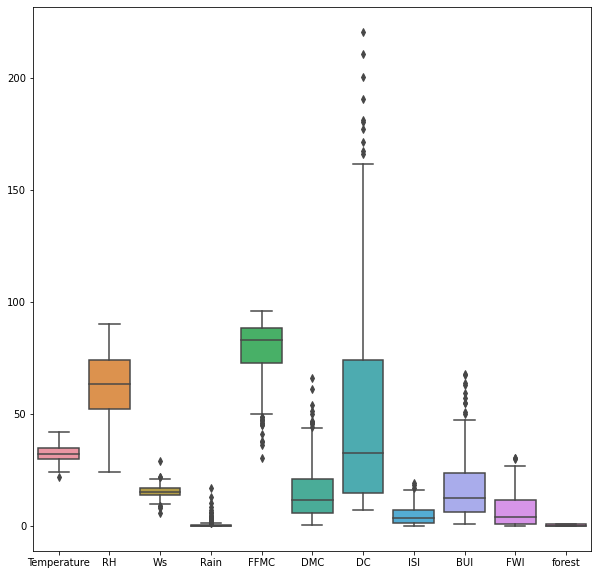

In [36]:
plt.figure(figsize=(10,10))
sns.boxplot(data=features)

In [37]:
scaler = StandardScaler()
features[features.columns] = scaler.fit_transform(features)

<AxesSubplot:>

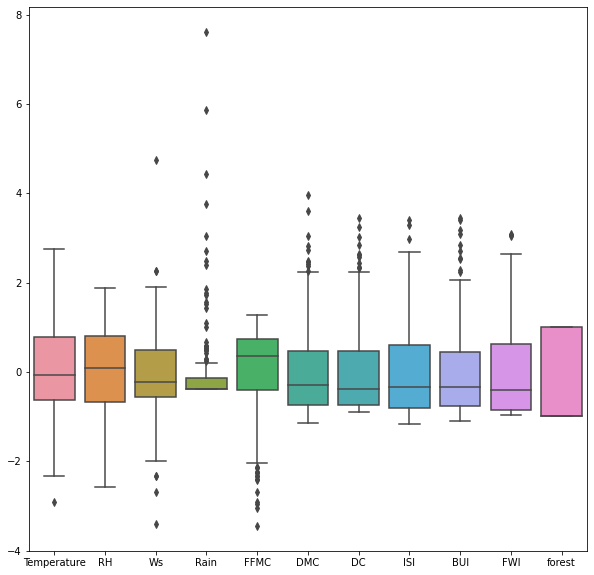

In [38]:
plt.figure(figsize=(10,10))
sns.boxplot(data=features)

There seems to be outliers in the data . Rain seems to be the most outlier.

<AxesSubplot:xlabel='Rain', ylabel='Classes'>

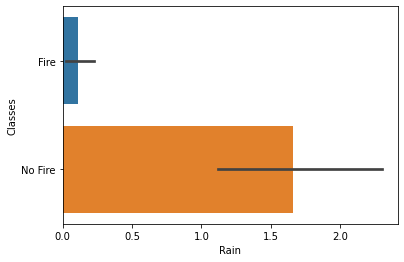

In [39]:
sns.barplot(x='Rain', y='Classes', data=train_data_df)

<AxesSubplot:xlabel='Rain', ylabel='Count'>

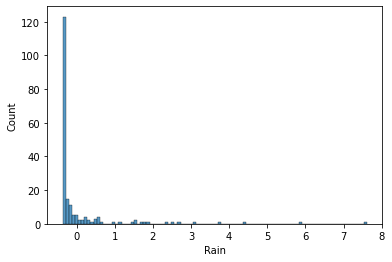

In [40]:
sns.histplot(x='Rain',data=features)

In [41]:
q1 = features['Rain'].quantile(0.25)
q3 = features['Rain'].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5*iqr
lower_bound = q1 - 1.5*iqr

In [11]:
q1

NameError: name 'q1' is not defined

In [42]:
rain_upper_bound = features [features['Rain'] > upper_bound].index.to_list()

In [43]:
train_data_df.loc[rain_upper_bound]

Temperature    RH    Ws       Rain       FFMC   DMC    DC  ISI   BUI  \
0           29.0  80.0  14.0   2.000000  48.700001   2.2   7.6  0.3   2.6   
6           25.0  78.0  14.0   1.400000  45.000000   1.9   7.5  0.2   2.4   
21          32.0  67.0  14.0   4.500000  64.599998   4.4   8.2  1.0   4.2   
31          34.0  51.0  16.0   3.800000  77.500000   8.0   9.5  2.0   7.7   
39          32.0  68.0  14.0   1.400000  66.599998   7.7   9.2  1.1   7.4   
44          34.0  42.0  15.0   1.700000  79.699997  12.0   8.5  2.2  11.5   
45          35.0  47.0  18.0   6.000000  80.800003   9.8   9.7  3.1   9.4   
67          30.0  52.0  15.0   2.000000  72.300003  11.4   7.8  1.4  10.9   
71          28.0  80.0  21.0  16.799999  52.500000   8.7   8.7  0.6   8.3   
80          30.0  77.0  21.0   1.800000  58.500000   1.9   8.4  1.1   2.4   
88          25.0  76.0  17.0   7.200000  46.000000   1.3   7.5  0.2   1.8   
98          22.0  86.0  15.0  10.100000  30.500000   0.7   7.0  0.0   1.1   
102         28.0  87.0  15.0   4.400000  41.099998   6.5   8.0  0.1   6.2   
112         30.0  54.0  14.0   3.100000  70.500000  11.0   9.1  1.3  10.5   
114         36.0  43.0  15.0   1.900000  82.300003   9.4   9.9  3.2   9.0   
115         28.0  51.0  17.0   1.300000  71.400002   7.7   7.4  1.5   7.3   
134         34.0  56.0  15.0   2.900000  74.800003   7.1   9.5  1.6   6.8   
138         26.0  80.0  16.0   1.800000  47.400002   2.9   7.7  0.3   3.0   
142         33.0  62.0  10.0   8.700000  65.500000   4.6   8.3  0.9   4.4   
148         30.0  58.0  12.0   4.100000  66.099998   4.0   8.4  1.0   3.9   
154         33.0  73.0  12.0   1.800000  59.900002   2.2   8.9  0.7   2.7   
156         31.0  69.0  17.0   4.700000  62.200001   3.9   8.0  1.1   3.8   
167         26.0  49.0   6.0   2.000000  61.299999  11.9  28.1  0.6  11.9   
173         26.0  81.0  21.0   5.800000  48.599998   3.0   7.7  0.4   3.0   
179         30.0  73.0  13.0   4.000000  55.700001   2.7   7.8  0.6   2.9   
188         28.0  58.0  18.0   2.200000  63.700001   3.2   8.5  1.2   3.3   
189         34.0  71.0  14.0   6.500000  64.500000   3.3   9.1  1.0   3.5   
192         26.0  82.0  22.0  13.100000  47.099998   2.5   7.1  0.3   2.7   

     FWI  Classes                         forest  
0    0.1  No Fire  Sidi-Bel Abbes Region Dataset  
6    0.1  No Fire          Bejaia Region Dataset  
21   0.4  No Fire  Sidi-Bel Abbes Region Dataset  
31   1.3  No Fire  Sidi-Bel Abbes Region Dataset  
39   0.6  No Fire          Bejaia Region Dataset  
44   2.2  No Fire  Sidi-Bel Abbes Region Dataset  
45   3.0     Fire  Sidi-Bel Abbes Region Dataset  
67   0.9  No Fire  Sidi-Bel Abbes Region Dataset  
71   0.3  No Fire          Bejaia Region Dataset  
80   0.3  No Fire          Bejaia Region Dataset  
88   0.1  No Fire          Bejaia Region Dataset  
98   0.0  No Fire          Bejaia Region Dataset  
102  0.0  No Fire  Sidi-Bel Abbes Region Dataset  
112  0.8  No Fire  Sidi-Bel Abbes Region Dataset  
114  3.1     Fire  Sidi-Bel Abbes Region Dataset  
115  0.8  No Fire  Sidi-Bel Abbes Region Dataset  
134  0.8  No Fire  Sidi-Bel Abbes Region Dataset  
138  0.1  No Fire          Bejaia Region Dataset  
142  0.4  No Fire  Sidi-Bel Abbes Region Dataset  
148  0.4  No Fire  Sidi-Bel Abbes Region Dataset  
154  0.3  No Fire          Bejaia Region Dataset  
156  0.4  No Fire  Sidi-Bel Abbes Region Dataset  
167  0.4  No Fire  Sidi-Bel Abbes Region Dataset  
173  0.1  No Fire          Bejaia Region Dataset  
179  0.2  No Fire  Sidi-Bel Abbes Region Dataset  
188  0.5  No Fire  Sidi-Bel Abbes Region Dataset  
189  0.4  No Fire  Sidi-Bel Abbes Region Dataset  
192  0.1  No Fire          Bejaia Region Dataset

In [44]:
train_data_df[train_data_df['Rain']==0]

Temperature    RH    Ws  Rain       FFMC        DMC          DC   ISI  \
1           35.0  38.0  15.0   0.0  92.099998  51.299999  147.699997  12.2   
3           32.0  81.0  17.0   0.0  84.599998  21.100000   42.299999   4.7   
4           36.0  54.0  18.0   0.0  89.400002  20.000000  110.900002   9.7   
5           34.0  53.0  18.0   0.0  89.000000  21.600000   80.300003   9.2   
7           39.0  43.0  12.0   0.0  91.699997  16.500000   30.900000   9.6   
..           ...   ...   ...   ...        ...        ...         ...   ...   
184         31.0  66.0  11.0   0.0  85.699997   8.300000   24.900000   4.0   
185         33.0  66.0  14.0   0.0  85.900002   7.600000   27.900000   4.8   
186         31.0  72.0  14.0   0.0  84.199997   8.300000   25.200001   3.8   
190         32.0  51.0  13.0   0.0  88.699997  16.000000   50.200001   6.9   
191         34.0  64.0  14.0   0.0  88.900002  40.500000  171.300003   9.0   

           BUI   FWI Classes                         forest  
1    54.900002  26.9    Fire  Sidi-Bel Abbes Region Dataset  
3    20.900000   7.7    Fire  Sidi-Bel Abbes Region Dataset  
4    27.500000  16.1    Fire          Bejaia Region Dataset  
5    25.799999  15.0    Fire          Bejaia Region Dataset  
7    16.400000  12.7    Fire  Sidi-Bel Abbes Region Dataset  
..         ...   ...     ...                            ...  
184   9.000000   4.1    Fire          Bejaia Region Dataset  
185   9.100000   4.9    Fire          Bejaia Region Dataset  
186   9.100000   3.9    Fire  Sidi-Bel Abbes Region Dataset  
190  17.799999   9.8    Fire  Sidi-Bel Abbes Region Dataset  
191  50.900002  20.9    Fire          Bejaia Region Dataset  

[109 rows x 12 columns]

In [45]:
train_data_df[train_data_df['Rain']==0]['Classes'].value_counts()

Fire       93
No Fire    16
Name: Classes, dtype: int64

In [46]:
train_data_df[train_data_df['Rain']!=0]['Classes'].value_counts()

No Fire    68
Fire       17
Name: Classes, dtype: int64

In [47]:
train_data_df.loc[rain_upper_bound]['Classes'].value_counts()

No Fire    26
Fire        2
Name: Classes, dtype: int64

In [48]:
train_data_df.loc[rain_upper_bound]['Classes'] == "Fire"

0      False
6      False
21     False
31     False
39     False
44     False
45      True
67     False
71     False
80     False
88     False
98     False
102    False
112    False
114     True
115    False
134    False
138    False
142    False
148    False
154    False
156    False
167    False
173    False
179    False
188    False
189    False
192    False
Name: Classes, dtype: bool

In [49]:
train_data_df.loc[[114,45]]

Temperature    RH    Ws  Rain       FFMC  DMC   DC  ISI  BUI  FWI  \
114         36.0  43.0  15.0   1.9  82.300003  9.4  9.9  3.2  9.0  3.1   
45          35.0  47.0  18.0   6.0  80.800003  9.8  9.7  3.1  9.4  3.0   

    Classes                         forest  
114    Fire  Sidi-Bel Abbes Region Dataset  
45     Fire  Sidi-Bel Abbes Region Dataset

In [50]:
train_data_df.drop([114,45], axis=0, inplace=True)

In [51]:
features.drop([114,45], axis=0, inplace=True)
labels.drop([114,45], axis=0, inplace=True)

WE drop the out value which has Fire and is upper bound of the rain 


	Temperature	RH	Ws	Rain	FFMC	DMC	DC	ISI	BUI	FWI	Classes	forest
114	36.0	43.0	15.0	1.9	82.300003	9.4	9.9	3.2	9.0	3.1	Fire	Sidi-Bel Abbes Region Dataset
45	35.0	47.0	18.0	6.0	80.800003	9.8	9.7	3.1	9.4	3.0	Fire	Sidi-Bel Abbes Region Dataset

In [52]:
features['Rain']= features['Rain'].apply(lambda x: upper_bound if x > upper_bound else x)

<AxesSubplot:>

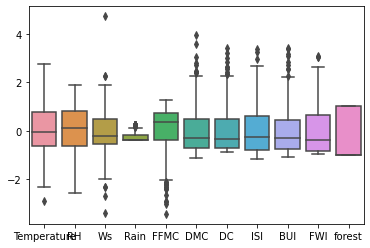

In [53]:
sns.boxplot(data=features)

In [54]:
features.columns

Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'FWI', 'forest'],
      dtype='object')

<AxesSubplot:xlabel='FFMC', ylabel='Count'>

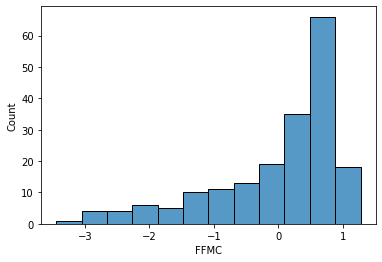

In [55]:
sns.histplot(data=features , x='FFMC')

In [56]:
q1 = features['FFMC'].quantile(0.25)
q3 = features['FFMC'].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5*iqr
lower_bound = q1 - 1.5*iqr

In [57]:
features[features['FFMC']< lower_bound]

Temperature        RH        Ws      Rain      FFMC       DMC        DC  \
0      -0.920196  1.204630 -0.567430  0.223385 -2.134346 -1.017462 -0.879373   
2      -0.920196  1.811989 -0.921390 -0.037966 -3.043566 -1.056536 -0.879373   
6      -2.053643  1.069661 -0.567430  0.223385 -2.401339 -1.040906 -0.881403   
52     -0.920196  1.677020 -0.213471 -0.180521 -2.228154 -0.861165 -0.871251   
53     -1.486919  1.677020  4.741966 -0.133002 -2.336394 -0.915868 -0.873281   
88     -2.053643  0.934693  0.494449  0.223385 -2.329178 -1.087795 -0.881403   
98     -2.903728  1.609536 -0.213471  0.223385 -3.447663 -1.134684 -0.891556   
102    -1.203557  1.677020 -0.213471  0.223385 -2.682764 -0.681423 -0.871251   
108    -2.337004  1.339599 -0.213471 -0.180521 -2.408555 -1.119055 -0.885464   
138    -1.770281  1.204630  0.140489  0.223385 -2.228154 -0.962758 -0.877342   
151    -0.920196  1.609536  0.140489 -0.370594 -2.913677 -1.119055 -0.867190   
160    -0.636834  1.811989  0.140489 -0.085484 -2.956973 -1.103425 -0.875312   
173    -1.770281  1.272114  1.910288  0.223385 -2.141562 -0.954943 -0.877342   
192    -1.770281  1.339599  2.264248  0.223385 -2.249802 -0.994017 -0.889525   

          ISI       BUI       FWI    forest  
0   -1.083713 -0.996470 -0.946971  1.010363  
2   -1.155639 -1.023621 -0.960323 -0.989743  
6   -1.107688 -1.010045 -0.946971 -0.989743  
52  -1.107688 -0.894653 -0.946971  1.010363  
53  -1.059737 -0.942168 -0.933620  1.010363  
88  -1.107688 -1.050772 -0.946971 -0.989743  
98  -1.155639 -1.098286 -0.960323 -0.989743  
102 -1.131663 -0.752111 -0.960323  1.010363  
108 -1.107688 -1.077923 -0.960323 -0.989743  
138 -1.083713 -0.969319 -0.946971 -0.989743  
151 -1.131663 -1.077923 -0.960323  1.010363  
160 -1.155639 -1.064347 -0.960323 -0.989743  
173 -1.059737 -0.969319 -0.946971 -0.989743  
192 -1.083713 -0.989682 -0.946971 -0.989743

In [58]:
train_data_df.loc[features[features['FFMC']< lower_bound].index.to_list()]

Temperature    RH    Ws  Rain       FFMC  DMC   DC  ISI  BUI  FWI  \
0           29.0  80.0  14.0   2.0  48.700001  2.2  7.6  0.3  2.6  0.1   
2           29.0  89.0  13.0   0.7  36.099998  1.7  7.6  0.0  2.2  0.0   
6           25.0  78.0  14.0   1.4  45.000000  1.9  7.5  0.2  2.4  0.1   
52          29.0  87.0  15.0   0.4  47.400002  4.2  8.0  0.2  4.1  0.1   
53          27.0  87.0  29.0   0.5  45.900002  3.5  7.9  0.4  3.4  0.2   
88          25.0  76.0  17.0   7.2  46.000000  1.3  7.5  0.2  1.8  0.1   
98          22.0  86.0  15.0  10.1  30.500000  0.7  7.0  0.0  1.1  0.0   
102         28.0  87.0  15.0   4.4  41.099998  6.5  8.0  0.1  6.2  0.0   
108         24.0  82.0  15.0   0.4  44.900002  0.9  7.3  0.2  1.4  0.0   
138         26.0  80.0  16.0   1.8  47.400002  2.9  7.7  0.3  3.0  0.1   
151         29.0  86.0  16.0   0.0  37.900002  0.9  8.2  0.1  1.4  0.0   
160         30.0  89.0  16.0   0.6  37.299999  1.1  7.8  0.0  1.6  0.0   
173         26.0  81.0  21.0   5.8  48.599998  3.0  7.7  0.4  3.0  0.1   
192         26.0  82.0  22.0  13.1  47.099998  2.5  7.1  0.3  2.7  0.1   

     Classes                         forest  
0    No Fire  Sidi-Bel Abbes Region Dataset  
2    No Fire          Bejaia Region Dataset  
6    No Fire          Bejaia Region Dataset  
52   No Fire  Sidi-Bel Abbes Region Dataset  
53   No Fire  Sidi-Bel Abbes Region Dataset  
88   No Fire          Bejaia Region Dataset  
98   No Fire          Bejaia Region Dataset  
102  No Fire  Sidi-Bel Abbes Region Dataset  
108  No Fire          Bejaia Region Dataset  
138  No Fire          Bejaia Region Dataset  
151  No Fire  Sidi-Bel Abbes Region Dataset  
160  No Fire          Bejaia Region Dataset  
173  No Fire          Bejaia Region Dataset  
192  No Fire          Bejaia Region Dataset

we can see the lower bound has only one class No fire 

In [59]:
features.shape , labels.shape

((192, 11), (192,))

In [60]:
train_data_df.shape

(192, 12)

In [61]:
features

Temperature        RH        Ws      Rain      FFMC       DMC        DC  \
0      -0.920196  1.204630 -0.567430  0.223385 -2.134346 -1.017462 -0.879373   
1       0.779975 -1.629712 -0.213471 -0.370594  0.997411  2.819631  1.965357   
2      -0.920196  1.811989 -0.921390 -0.037966 -3.043566 -1.056536 -0.879373   
3      -0.070110  1.272114  0.494449 -0.370594  0.456209  0.459546 -0.174789   
4       1.063337 -0.549962  0.848409 -0.370594  0.802579  0.373582  1.218133   
..           ...       ...       ...       ...       ...       ...       ...   
189     0.496613  0.597271 -0.567430  0.223385 -0.994213 -0.931498 -0.848915   
190    -0.070110 -0.752415 -0.921390 -0.370594  0.752066  0.060988 -0.014380   
191     0.496613  0.124881 -0.567430 -0.370594  0.766499  1.975627  2.444555   
192    -1.770281  1.339599  2.264248  0.223385 -2.249802 -0.994017 -0.889525   
193    -0.070110 -0.549962 -1.629310 -0.133002 -0.330338 -0.572015 -0.416419   

          ISI       BUI       FWI    forest  
0   -1.083713 -0.996470 -0.946971  1.010363  
1    1.769359  2.553524  2.631279  1.010363  
2   -1.155639 -1.023621 -0.960323 -0.989743  
3   -0.028795  0.245689  0.067756  1.010363  
4    1.169975  0.693680  1.189297 -0.989743  
..        ...       ...       ...       ...  
189 -0.915885 -0.935380 -0.906916  1.010363  
190  0.498664  0.035268  0.348142  1.010363  
191  1.002147  2.282014  1.830178 -0.989743  
192 -1.083713 -0.989682 -0.946971 -0.989743  
193 -0.867934 -0.521327 -0.866861 -0.989743  

[192 rows x 11 columns]

In [21]:
Load_and_transform()

Loading Raw_data from MongoDB
Dropped Collection : PROCEEDED_DATA
Reading the data from the database
Dataframe created successfully
Loaded Raw_data from MongoDB as Dataframe
Memory usage decreased from 0.05MB to 0.01MB (0.04MB, 80.21% reduction)
Dropped columns : 'month' , 'year' , 'day' from Dataframe , as they are not significant
Dropped rows : 114 and 45 from Dataframe , as they are as the day has rain and has fire is a outlier using IQR
Converted categorical columns to numerical columns
Scaled Dataframe
Saved scaler as pickle file/home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/SCALER_DIR
Imputed Dataframe
Saved imputer as pickle file/home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/IMPUTER_DIR
Clipped Rain column
Saved processed data as csv file in /home/pk/Desktop/Eda/Algerian_forest_fires_dataset/Artifacts/PROCEEDED_DATA
Inserted processed data into MongoDB PROCEEDED_DATA


True

In [63]:
MONGO_DB = CN.MONGO_DB_NAME
PROCESSED_COLLECTION = CN.MONGO_PROCESSED_COLLECTION

In [ ]:
Conn_obj_Processed = MongoDB( MONGO_DB , PROCESSED_COLLECTION)

In [162]:
labels = labels.map({'Fire':1 , 'No Fire':0})

In [165]:
features.isnull().sum()

Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
forest         0
dtype: int64

In [65]:
features_11 = select_features(features , labels , N2_select= 10)

In [67]:
features_11.columns

Index(['Score_VIF', 'Score_EXtraTree', 'Score_mutual_info', 'Score_RFE'], dtype='object')

In [68]:
featues_11.sort_values(by=['Score_VIF'])

Score_VIF  Score_EXtraTree  Score_mutual_info  Score_RFE
Ws             1.263556         0.010129           0.000000          1
Rain           1.500100         0.160169           0.312944          1
forest         1.723699         0.010175           0.067635          2
Temperature    2.153060         0.032734           0.189355          1
RH             2.786454         0.024122           0.081358          1
FFMC           3.836625         0.169977           0.629598          1
ISI           19.478135         0.166000           0.635063          1
DC            23.254795         0.054642           0.342551          1
FWI           34.954691         0.225424           0.574737          1
DMC           77.163093         0.062967           0.343231          1
BUI          156.903040         0.083661           0.340451          1